# Visualization of signal flow in EARM with two different calibrated parameter sets

## *This notebook reproduces the Figure 3 in the paper

### We start by importing the libraries required to do the analysis and the visualizations

In [1]:
from pyvipr.pysb_models.lopez_embedded import model
import pyvipr as viz
import numpy as np
from pysb.simulator import ScipyOdeSimulator
import os
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from numpy import genfromtxt
%matplotlib inline

# Obtaining maximally different parameter sets

### First, we load the calibrated parameters obtained with the Particle Swarm Optimization algorithm. Next, we standardize the parameter set values using the StandardScaler() class from sklearn. Then, we applied an euclidean distance and choose the two parameters that are the most dissimilar.

In [2]:
# Standardization of calibrated parameters by removing the mean and scaling to unit variance

pars = np.load('calibrated_6572pars.npy')
kpars_idxs = [i for i, j in enumerate(model.parameters) if not j in model.parameters_initial_conditions()]
kpars = pars[:, kpars_idxs]
kpars_means = np.mean(kpars, axis=0)
kpars_means = np.tile(kpars_means, (kpars.shape[0], 1))
kpars_stds = np.std(kpars, axis=0)
kpars_stds = np.tile(kpars_stds, (kpars.shape[0], 1))

kpars_standard = (kpars - kpars_means) / kpars_stds

In [3]:
# Calculate the pairwise distances
dis = squareform(pdist(kpars_standard, metric='euclidean'))

In [4]:
# Obtain the two most dissimilar parameters
ind = np.unravel_index(np.argmax(dis, axis=None), dis.shape)
ind

(4697, 5023)

### The parameter sets with the index 4697 and 5023 are the most dissimilar.

### We load the experimental data to confirm that the calibrated parameters actually fit the data, and create a new function called display that plots the experimental data alongside the simulated trajectories of the calibrated parameter set.

In [5]:
# load experimental data

data_path = os.path.join(os.path.abspath(''), 'data',
                         'EC-RP_IMS-RP_IC-RP_data_for_models.csv')

exp_data = genfromtxt(data_path, delimiter=',', names=True)
# Mean and variance of Td (delay time) and Ts (switching time) of MOMP, and
# yfinal (the last value of the IMS-RP trajectory)
momp_data = np.array([9810.0, 180.0, model.parameters['Smac_0'].value])
momp_var = np.array([7245000.0, 3600.0, 1e4])

In [6]:
def display(position, save_name):
    param_values = position
    traj = solver.run(param_values=param_values)

    # normalize trajectories
    bid_traj = traj.observables['mBid'] / model.parameters['Bid_0'].value
    cparp_traj = traj.observables['cPARP'] / model.parameters['PARP_0'].value
    aSmac_traj = traj.observables['aSmac'] / model.parameters['Smac_0'].value

    # create all plots for each observable
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9, 3), sharex=True, sharey=True)

    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.xlabel("Time(s)")
    plt.ylabel("Population")
    
    # plot cleaved parp
    ax[0].plot(tspan, bid_traj, color='r', marker='^', label='tBID sim')
    ax[0].errorbar(exp_data['Time'], exp_data['norm_ICRP'],
                 yerr=exp_data['nrm_var_ICRP'] ** .5,
                 ecolor='black', color='black', elinewidth=0.5, capsize=0)
    ax[0].legend(loc=2)

    # plot cleaved parp
    ax[1].plot(tspan, cparp_traj, color='blue', marker='*', label='cPARP sim')
    ax[1].errorbar(exp_data['Time'], exp_data['norm_ECRP'],
                 yerr=exp_data['nrm_var_ECRP'] ** .5,
                 ecolor='black', color='black', elinewidth=0.5, capsize=0)
    ax[1].legend(loc=2)

    # plot activated SMAC
    ax[2].plot(tspan, aSmac_traj, color='g', label='aSMAC sim')
    ax[2].axvline(momp_data[0], -0.05, 1.05, color='black', linestyle=':',
                label='exp aSMAC')
    ax[2].legend(loc=2)
    plt.show
#     fig.savefig('{}.png'.format(save_name), dpi=500, bbox_inches='tight')
#     plt.close()

# Parameter 1 visualization: Bid-Bax dominant reaction

### First, we make sure that the calibrated parameter actually fit the experimental data. To do this, we run a simulation with the parameter set 4697 and then plot the experimental data and the simulation results.

In [7]:
pars4697 = pars[4697]
tspan = np.linspace(0, 20000, 100)
sim = ScipyOdeSimulator(model, tspan, compiler='python').run(param_values=[pars4697])

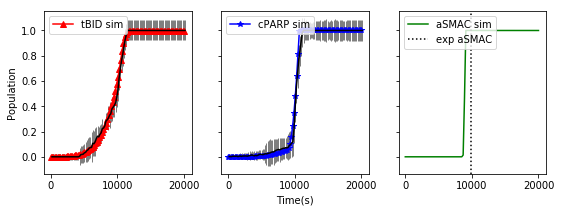

In [8]:
solver = ScipyOdeSimulator(model, tspan, compiler='python')
display(pars4697, 'data_calibration_par4697')

### By visually inspecting the experimental data and the simulation, we see that the simulation results fit the experimental data. Then, we proceed to explore the dynamics of the model with that parameter by using the function sp_dyn_view from pyvipr.

### We focus on the dynamics of mitochondrial Bid because it plays an important role in the regulation of Mitochondrial Outer Membrane Permeabilization. We click the mBid node in the graph to highlight all the species to which mBid can interact.

In [9]:
viz.sp_dyn_view(sim, layout_name='klay')

pysbViz(data=<pysb.simulator.base.SimulationResult object at 0xa1366e2e8>, layout_name='klay', type_of_viz='dy…

### For this parameter set, we observed that most of mBid was used to transport cytosolic Bax to MOM while no activation of Bak occurred, indicating that the pores in MOM were primarily made by Bax and that the model with this parameter set is particularly sensitive to Bax inhibition

### To verify our visualization-based analysis, we carried out an in-silico experiment. We did a Bax knockout and ran a simulation of EARM with the parameter set 4697.

In [10]:
pars_bax_ko= np.copy(pars4697)
pars_mcl1_ko= np.copy(pars4697)
pars_bax_ko[63] = pars_bax_ko[63] * 0
pars_mcl1_ko[57] = pars_mcl1_ko[57] * 0
sim_kd_bax = ScipyOdeSimulator(model, tspan, compiler='python').run(param_values=[pars_bax_ko, pars_mcl1_ko])

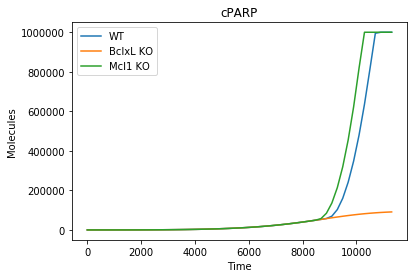

In [11]:
plt.plot(tspan[:57], sim.all['cPARP'][:57], label='WT')
plt.plot(tspan[:57], sim_kd_bax.all[0]['cPARP'][:57], label='BclxL KO')
plt.plot(tspan[:57], sim_kd_bax.all[1]['cPARP'][:57], label='Mcl1 KO')
plt.xlabel('Time')
plt.ylabel('Molecules')
plt.title('cPARP')
plt.legend()
plt.savefig('par4697_bax_ko.png', dpi=500, bbox_inches='tight')

### We found that the knockout protected cells from apoptosis induction with TRAIL, confirming that Bax has an essential role in apoptosis.

# Parameter 2 visualization: Bid-Mcl1 dominant reaction

### First, we make sure that the calibrated parameter actually fit the experimental data. To do this, we run a simulation with the parameter set 5023 and then plot the experimental data and the simulation results

In [12]:
pars2 = pars[5023]
sim2 = ScipyOdeSimulator(model, tspan, compiler='python').run(param_values=pars2)

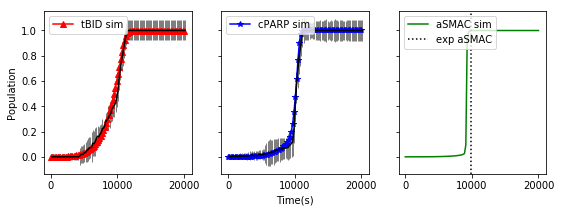

In [13]:
display(pars2, 'data_calibration_par5023')

### By visually inspecting the experimental data and the simulation, we see that the simulation results fit the experimental data. Then, we proceed to explore the dynamics of the model with that parameter set by using the function sp_dyn_view from pyvipr.

In [14]:
viz.sp_dyn_view(sim2, layout_name='klay')

pysbViz(data=<pysb.simulator.base.SimulationResult object at 0x151c282eb8>, layout_name='klay', type_of_viz='d…

### For the parameter set 2 we observed that mBid activity was inhibited primarily by the anti-apoptotic protein Mcl1, indicating that it plays an important role in throttling apoptosis

### To verify our visualization-based analysis, we carried out another in-silico experiment. We did an Mcl1 knockout and ran a2 simulation of EARM with the parameter set 2.  

In [15]:
pars_for_mcl1_kd = np.copy(pars2)
pars_for_bax_kd = np.copy(pars2)
pars_for_mcl1_kd[57] = pars_for_mcl1_kd[57] * 0
pars_for_bax_kd[63] = pars_for_bax_kd[63] * 0
sim_kd_bcl2 = ScipyOdeSimulator(model, tspan, compiler='python').run(param_values=[pars_for_mcl1_kd, pars_for_bax_kd])

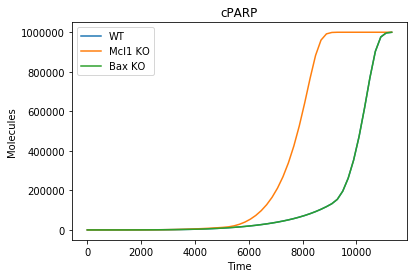

In [16]:
plt.plot(tspan[:57], sim2.all['cPARP'][:57], label='WT')
plt.plot(tspan[:57], sim_kd_bcl2.all[0]['cPARP'][:57], label='Mcl1 KO')
plt.plot(tspan[:57], sim_kd_bcl2.all[1]['cPARP'][:57], label='Bax KO')
plt.xlabel('Time')
plt.ylabel('Molecules')
plt.title('cPARP')
plt.legend()
plt.savefig('par5023_mcl1_ko.png', dpi=500, bbox_inches='tight')

### We found that time-to-death was reduced by y%, corroborating that Mcl1 was delaying the apoptosis execution by binding to mBid.  

### These results demonstrated that although these two parameter sets fit the data equally well, they executed the apoptosis signal in different ways; specifically, in this case the parameter sets determined whether Bax or Mcl1 played the key role in regulating apoptosis execution.

In [17]:
from scipy.optimize import curve_fit

def sig_apop(t, f, td, ts):
    """

    Parameters
    ----------
    t : list-like
        Time variable in the function
    f : float
        is the fraction cleaved at the end of the reaction
    td : float
        is the delay period between TRAIL addition and half-maximal substrate cleavage
    ts : float
        is the switching time between initial and complete effector substrate  cleavage

    Returns
    -------

    """
    return f - f / (1 + np.exp((t - td) / (4 * ts)))

#     xdata: list-like,
#         x-axis data points (usually time span of the simulation)
#     ydata: list-like,
#         y-axis data points (usually concentration of species in time)

c = curve_fit(f=sig_apop, xdata=tspan, ydata=sim.all['cPARP'], p0=[10,10,10])
